## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner.
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**.
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Case Study: Bayesian classifier

## Part 1: A Bayesian classifier and performance evaluation

In this case study you will:
1. Build, train, and test a Bayesian classifier. This will increase your understanding of parametric models for supervised learning.
2. Implement the model as a Python class, in a manner similar to those of scikit-learn. This will improve you understanding of what goes on under the hood of scikit-learn models.
3. Evaluate performance of your Bayesian classifer, but also of some "foolish" classifiers. This will alert you to the sometimes misleadingly high performance scores a model might give, even when it has not learning any relationship between features and targets.

### In this Part 1 notebook you will focus solely on the Bayesian classifier and its evaluation. In the Part 2 notebook you will build the foolish classifiers and compare evaluation results with those of the Bayesian classifier.

## The Bayesian classifier

In this course you have been introduced to one particular type of Bayesian classifier--the Naive Bayes classifer. In that model, it is assumed that all data features are independent of one another, thus substantially reducing the complexity of the posterior probability equation. In this notebook we will not assume independence but we will assume that feature distributions are multivariate Gaussian with no covariance between features--i.e., the covariance matrix is a diagonal matrix. For a given class/label, just think of blobs of samples in n-dimensional space, with different standard deviations ("widths") in each dimension and no "diagonal" aspect to the blobs--like in the 2D distribution in the image below, which has different standard deviations in the vertical and horizontal directions, but no covariance between them.

| ![A 2D Gaussian distribution with diagonal covariance matrix, fitted to noisy data.](./2d_noisy_gaussian.png) |
|:--:|
| A 2D Gaussian distribution with diagonal covariance matrix, fitted to noisy data. |

Recall our Bayesian formulation of a supervised learning classification problem. For class $y$ and feature vector $\mathbf{x}$,

$$P(y|\mathbf{x}) = \frac{P(\mathbf{x}|y)P(y)}{P(\mathbf{x})}$$

For a given feature vector, $\mathbf{x}$, our goal is to find the label $y$ that gives the largest value for $P(y|\mathbf{x})$. Because $\mathbf{x}$ is a fixed sample, $P(\mathbf{x})$ is a constant, and this goal is equivalent to finding the label $y$ that maximizes $P(\mathbf{x}|y)P(y)$. Thus, we must use our training set to estimate $P(\mathbf{x}|y)$ and $P(y)$, and save that information for when we use the model to make class predictions from features.

We will assume that for a given class, $y$, the distribution $P(\mathbf{x}|y)$ is Gaussian, with covariance between features equal to 0. Furthermore, we will work with data that has only two features, $x_1$ and $x_2$, and can thus write our probabilities as:

$$ P(x_1,x_2|y)=\frac{ exp\Big(-(\frac{{(x_1-\mu_{y,1})}^2}{\sigma_{y,1}^2} + \frac{{(x_2-\mu_{y,2})}^2}{\sigma_{y,2}^2}) /2\Big) }{2\pi\sigma_{y,1}\sigma_{y,2}}  $$

where $\mu_{y,k}$ and $\sigma_{y,k}$ are the mean and standard deviation of the $k$th feature for samples in class $y$, respectively. Thus, our final equation for our model's prediction, $\tilde{y}$ is:

$$ \tilde{y} = \underset{y}{\operatorname{argmax}} \Bigg[\frac{ exp\Big(-(\frac{{(x_1-\mu_{y,1})}^2}{\sigma_{y,1}^2} + \frac{{(x_2-\mu_{y,2})}^2}{\sigma_{y,2}^2}) /2\Big) }{2\pi\sigma_{y,1}\sigma_{y,2}} P(y) \Bigg] $$


__The above equation is your model, and you will use training data to estimate the ${P(y)}$ and the $\mu$ and $\sigma$ parameters, and the equation itself to make predictions."__ It may look complicated, but don't worry, we'll guide you through the coding!

## The model's Python class

You will create a Python class from scratch (aside from the skeleton we have provided) that will implement three methods that are part of most scikit-learn model classes:

`fit(X, y)` - Trains the model using features X and label y, and stores the learned (fitted) model parameters as class object attributes.

`predict(X)` - Using the stored model parameters, predicts labels for features X, and returns them.

`fit_predict(X, y)` - Sequentially performs the actions of `fit()` and `predict()`, storing learned model parameters and using those parameters to compute and return its predictions __for the same__ features, X, that are used when fitting. Not all scikit-learn models implement this method. It is often just a convenience function that literally calls `fit()` and then `predict()`, but some scikit-learn models may use a distinct implementation that is more computationally efficient than sequential `fit()` and `predict()` calls. Note that this is not a substitute for splitting your data into train/val/test sets, as `fit_predict()` does not do data splitting.

Before you start coding your model class, `BayesClassifier`, keep in mind the manner in which it will be used...

```python
# A user instantiates the model class, indicating how many classes there
# are in the initialization call.
bayes_clf = BayesClassifer(n_classes=3)

# The user then uses the class object to train on a subset of their data.
# In this case they'll obtain the predictions for the training set as well.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_pred_train = bayes_clf.fit_predict(X_train, y_train)

# The user then makes predictions for the test set.
y_pred_test = bayes_clf.predict(X_test)

# Finally, the user computes evaluation metric scores for y_pred_train
# and y_pred_test (we'll discuss this later in the notebook).
```

A skeleton of your code is in the cell below, along with guiding comments. Note that typically a developer writes a lot of code that ensures that the user is calling methods with necessary and sufficient arguments, of the appropriate type and range. We will ignore that but you are welcome to include such safechecks (e.g., `assert` statements).

Write code for each of the methods of the class, implementing the Bayesian classifier as described above, for data with 2 and only 2 features. Note that the number of classes is a variable specified by the user--__you can assume that labels are integers numbered from 0 to N-1, for N classes.__ For example, if the user specifies that `n_classes=4` then you can assume they will provide a numpy array of labels that looks like `y=np.array([2,3,1,1,0,2,3,3])`. Labels __will not__ be of some other format, such as "red", "blue", "green".

__You may implement the methods using native/raw python and the math and/or numpy modules. You may not use scikit-learn, however. Use of numpy is suggested.__

`numpy.where()`: As hinted in the skeleton code below, during fitting, you'll need to find all the samples that belong to a given class, and then do something with that subset of samples (e.g., compute the mean). One way of doing that is by using `np.where()` to find the array indicies of the values that meet that criterion, and then index your feature array with those indices, to work on that subset of sample. The snippet of code below demonstrates its usage.

```python
In [1]: import numpy as np
   ...: np.random.seed(42)
   ...:                                                                                                                         

In [2]: # Create simple data  
   ...: labels = np.array([0, 1, 2, 1, 1, 0, 2])  
   ...: features = np.random.randint(0, high=10, size=len(labels))  
   ...: print(features)  
   ...:                                                                                                                         
[6 3 7 4 6 9 2]

In [3]: # Find the indices of samples of class/label 1.
   ...: # Note that np.where() returns a tuple of numpy arrays, even
   ...: # if the input to np.where() is only 1-dimensional. So you
   ...: # need to access the indices you want by extracting the
   ...: # 0th item of the tuple, using the results[0] syntax.
   ...: idx = np.where(labels==1)[0]
   ...: print(idx)
   ...: print(len(idx))  
   ...:                                                                                                                         
[1 3 4]
3

In [4]: # Compute the minimum feature value, for samples of class 1  
   ...: print(features[idx])  
   ...: min_val = np.min(features[idx])  
   ...: print(min_val)
   ...:                                                                                                                         
[3 4 6]
3

In [5]: # You could even do it all in one line..  
   ...: min_val = np.min(features[np.where(labels==1)[0]])  
   ...: print(min_val)
   ...:                                                                                                                         
3
```

As a final reminder, you are implementing a type of Bayesian classifier, but you are __not__ implementing a Naive Bayes classifier. A Gaussian Naive Bayes classifier would treat $P(x_1,x_2|y)$ as the product of two one-dimensional Gaussian instead: $P(x_1|y)P(x_2|y)$. Such a distribution has more of a rectangular look versus the elliptical look of the image in the cell above. You are welcome to examine scikit-learn's source code for the Naive Bayes classifier ([GaussianNB](https://github.com/scikit-learn/scikit-learn/blob/6c566da8c99b4908a549aeb659cd4b1124bc2448/sklearn/naive_bayes.py#L128)), but copying the code will not give identical results. If you are not an advanced Python user, don't worry if the scikit-learn source code is overwhelming. You're code can be much simpler, and you are probably better off ignoring the scikit-learn code.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

In [2]:
## Implement the three methods of your Bayesian classifier.
## YOU MAY NOT USE SCIKIT-LEARN IN THIS CELL.

class BayesClassifier():
    def __init__(self, n_classes):
        # Store the number of classes as a class attribute
        self.n_classes=n_classes

        # You may initialize other variables here if you want to,
        # such as an (empty) array for storing feature means
        # and variances, though it's not truly necessary.

        # YOUR CODE HERE
        self.means = np.zeros((n_classes, 2))
        self.variances = np.zeros((n_classes, 2))
        self.priors = np.zeros(n_classes)


    def fit(self, features, labels):
        # features - a numpy array of shape (n_samples, n_features==2)
        # labels - a numpy array of shape (n_samples,)
        #
        # This method does not return/output anything.

        # Use X and y to fit your model parameters.
        # For each of the 0 to self.n_classes-1 classes, you should:
        # 1. Determine which samples belong to that class, e.g., use np.where().
        # 2. Compute an estimate of the prior probability P(class), as the
        #    number of samples of that class, divided by the total number of samples.
        #    Store that value as an attribute, i.e., a variable that start with "self."
        #    Note that you'll likely want to store the prior probabilities in a
        #    single list or array, of length n_classes.
        # 3. Compute the mean and variance for both features, for those samples.
        #    You may use numpy.mean() and numpy.var()
        # 4. Store the means and variances as a class attribute, i.e., a
        #    variable that start with "self.". Again, you'll likely want to
        #    stores the means in a list or array. Same for the variances. You will
        #    have n_features*n_classes==2*n_classes means (and variances).
        # You may name your attribute variables anything that you wish, as allowed by python.

        # As a reminder, if you use the range() function to loop over
        # the class labels [0, 1, 2, ...] recall that range() excludes the
        # value of the argument you give it. That is, range(4) will iterate
        # over 0, 1, 2, and 3. It will exclude 4.

        # YOUR CODE HERE
        n_samples = len(labels)

        for i in range(self.n_classes):
          indices = np.where(labels == i)[0]
          self.priors[i] = len(indices)/n_samples

          if len(indices) == 0:
            continue

          class_features = features[indices]

          self.means[i] = np.mean(class_features, axis = 0)
          self.variances[i] = np.var(class_features, axis = 0, ddof = 0)
          self.variances[i] = np.maximum(self.variances[i], 1e-10)


    def predict(self, features):
        # features - a numpy array of shape (n_samples, n_features==2)
        #
        # Returns an array of predictions

        # Use your fitted model parameters to make label predictions for
        # the samples in 'features'.
        # 1. For each of the 0 to self.n_classes-1 classes, you should compute
        #    P(X|y=class)*P(y=class), for all samples, and store those values.
        # 2. For each/all samples, find the argmax across the n_class classes.
        #    You may use numpy.argmax().
        # 3. Return those argmax values, which are the label predictions.

        # YOUR CODE HERE
        n_samples = features.shape[0]
        log_probs = np.zeros((n_samples, self.n_classes))

        for i in range(self.n_classes):
          diff = features - self.means[i]
          exponent = -0.5 * np.sum((diff ** 2) / self.variances[i], axis = 1)

          log_normalizer = -np.log(2 * np.pi) - 0.5 * np.sum(np.log(self.variances[i]))
          log_probs[:, i] = exponent + log_normalizer + np.log(self.priors[i])
        return np.argmax(log_probs, axis=1)


    def fit_predict(self, features, labels):
        # features - a numpy array of shape (n_samples, n_features==2)
        # labels - a numpy array of shape (n_samples,)
        #
        # Returns an array of predictions

        # Fit your model by calling self.fit(features, labels)
        # Then make predictions by calling self.predict(features)
        # Finally, return those predictions.

        # YOUR CODE HERE
        self.fit(features, labels)
        return self.predict(features)

The cell below does a coarse check of your implementation of the BayesClassifier class. Unless you are a Python and numpy superstar, it will likely fail on your first try. It may not give you any meaningful feedback to help you debug your code.

To help with debugging, don't hesistate to:
1. Put print statements in your code above, to show you the contents of variables and ensure they hold the values you expect. Also print out helpful info such as a variables type (e.g., are you sure it's a numpy array? Or is it a list?... `print(type(my_variable))`, shape: `print(my_variable.shape)`, and length: `print(len(my_variable))`. Note that the output of the print statements will appear below the cell in which you classifier is instantiated, or one of its methods is called. It will not appear under the cell in which the class is defined (above).
2. Create a new cell below, and create simple data you can use to test your classifier (as in the autograder cell below).
3. If you instantiate your class, you can then view its attributes and their values as shown below:
```python
# Create object
clf = BayesClassifier(n_classes=4)
# print out the names of its attributes
print(clf.__dict__.keys())
# If an attribute is named "means" you can print out its values...
print(clf.means)
```
Keep in mind that depending on how you implemented your class, some attributes may not exist until the `fit()` method is called.

In [3]:
# Autograder: Create a few samples from 3 classes, with high class separation
n_classes = 3
y = np.array([0, 0, 1, 1, 2, 2])
X = np.array([[-1, 1], [1, -1], [2, 5], [5, 2], [-2, -5], [-5, -2]])

# Test fit() and predict()
clf = BayesClassifier(n_classes)
clf.fit(X, y)
y_pred = clf.predict(X)
assert np.array_equal(y, y_pred)

# Test fit_predict()
y_pred = clf.fit_predict(X, y)
assert np.array_equal(y, y_pred)

# Try with 4 classes also
n_classes = 4
y = np.array([0, 0, 1, 1, 2, 2, 3, 3])
X = np.array([[-1, 1], [1, -1], [2, 5], [5, 2], [-2, -5], [-5, -2], [10, 11], [11, 10]])

# Test fit() and predict()
clf = BayesClassifier(n_classes)
clf.fit(X, y)
y_pred = clf.predict(X)
assert np.array_equal(y, y_pred)

# Test fit_predict()
y_pred = clf.fit_predict(X, y)
assert np.array_equal(y, y_pred)

## Testing and visualization

Now that you've completed all that hard work, let's try it out, and visual some results. Since we are only using two features, we can easily display results in 2D plots.

Below, we create the usual synthetic "blobs" of samples, with class labels. We will train our model and then create a colormap that should the classifiers boundaries between classes. In most real-world cases your feature dimensionality will be too high to create such a colormap, but we do it here for edification.

In [4]:
# Create random samples of three classes, with samples drawn from multivariate Gaussian distributions
np.random.seed(42)
n1 = 10
mean1 = [0, 1]
cov1 = [[1, 0], [0, 1]]
n2 = 20
mean2 = [3, 2]
cov2 = [[0.1, 0], [0, 1]]
n3 = 70
mean3 = [1, 3]
cov3 = [[1, 0], [0, 0.5]]
X = [np.random.multivariate_normal(mean1, cov1, size=n1),
     np.random.multivariate_normal(mean2, cov2, size=n2),
     np.random.multivariate_normal(mean3, cov3, size=n3),
    ]
X = np.concatenate(X, axis=0)
y = np.array([0]*n1 + [1]*n2 + [2]*n3)

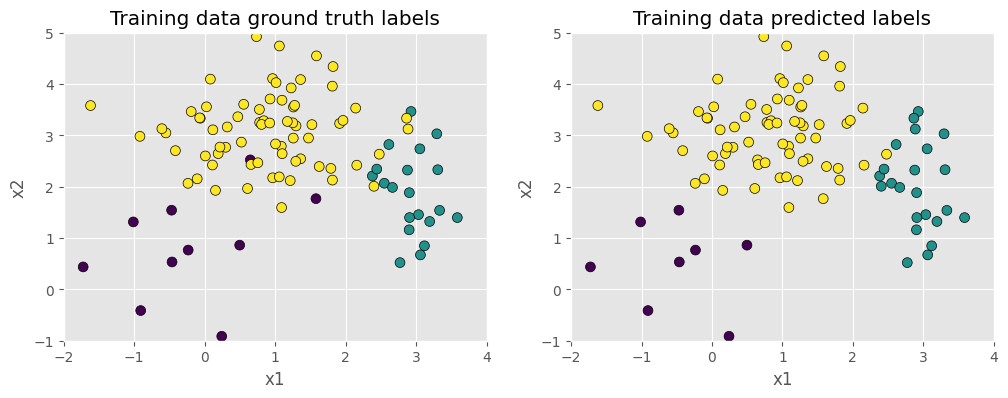

In [5]:
# Now let's train a model on the data set, then visualize the predictions,
# as a subjective check. The predicted sample labels, plotted on the left, should
# be color-coded much like the ground truth samples labels, plotted on the right,
# except in regions were ground truth classes "overlap."
#
# We're not yet concerned with evaluating a trained model's performance (on a
# validation or test set), so we'll just use all our data for training.

clf = BayesClassifier(n_classes=3)
y_pred = clf.fit_predict(X, y)

# Plot our synthetic data
plt.figure(figsize=(12, 4))
plt.clf()

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=50, edgecolor='k')
plt.title("Training data ground truth labels")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis([-2, 4, -1, 5])

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_pred, s=50, edgecolor='k')
plt.title("Training data predicted labels")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis([-2, 4, -1, 5])

plt.show()

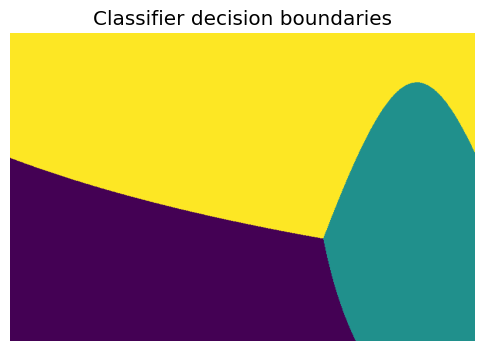

In [6]:
# Now lets create a map of the classification regions, and boundaries between them.
# To do so we'll create a set of features (x1 and x2 values) that densely span the space,
# get predictions for those features, and then plot the predicted labels as a colormap.
x1 = np.arange(-2, 4, 0.01)
x2 = np.arange(-1, 5, 0.01)
X1, X2 = np.meshgrid(x1, x2)
X_dense = np.stack((X1.flatten(), X2.flatten()), axis=1)
y_dense = clf.predict(X_dense)
y_dense = np.reshape(y_dense, (len(x1), len(x2)))

plt.figure(figsize=(6, 4))
plt.imshow(y_dense, aspect='auto')
plt.grid(False)
plt.axis('off')
plt.gca().invert_yaxis()
plt.xlabel('x1')
plt.xlabel('x2')
_ = plt.title('Classifier decision boundaries')

## The impact of the class prior distribution

If you wrote your classifier code correctly, all the images above should look commensurate, and hopefully you now have a better understanding of both Bayesian classifiers as well as how sckit-learn models are implemented. Great! But before we move on to evaluation metrics, let's do one more sanity check.

Remember that the Bayesian classifier takes into account the prior distribution of classes--that is, the $P(y)$ term in $P(\bar{x}|y)P(y)$. Imagine we have two classes with nearly the same feature distributions (means and variances) but one of those classes has notably fewer samples than the other class, i.e., it's prior is much lower. In that case, our Bayesian classifier should nearly always select the class that is more prevalent in the training set, since the $P(\bar{x}|y)$ terms are about the same for both classes. Let's see what your classifier does in that situation.


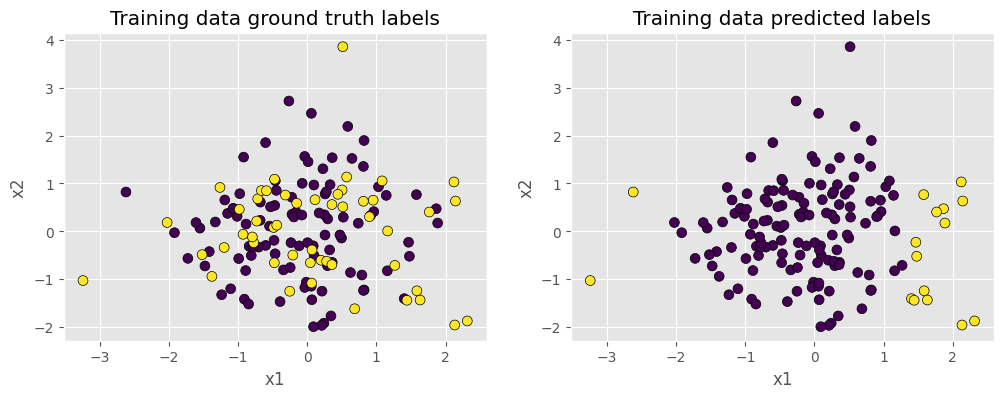

In [7]:
# Create random samples of two classes with identical feature distributions,
# but with many more samples of class 1 than class 2
np.random.seed(42)
XX = [np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=100),
     np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=50),
    ]
XX = np.concatenate(XX, axis=0)
yy = np.array([0]*100 + [1]*50)

# Let train, predict, and plot, as before...
clf = BayesClassifier(n_classes=2)
yy_pred = clf.fit_predict(XX, yy)

# Plot our synthetic data
plt.figure(figsize=(12, 4))
plt.clf()

plt.subplot(1, 2, 1)
plt.scatter(XX[:, 0], XX[:, 1], marker='o', c=yy, s=50, edgecolor='k')
plt.title("Training data ground truth labels")
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1, 2, 2)
plt.scatter(XX[:, 0], XX[:, 1], marker='o', c=yy_pred, s=50, edgecolor='k')
plt.title("Training data predicted labels")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

If all is well, you should see that the classifier predicted nearly all the samples to be of just one class--the class that had twice as many samples in the training data.

## Evaluation

Now, let's split our data into training and test sets, train the model, and then evaluate it. In this section you'll assess and score the model's test set predictions using tools we've discussed in the course:
- [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [precision, recall, and F-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html).

__We'll work with the 3-class synthetic data we initially created in this notebook.__

You can use scikit-learn for performing the evaluation, but should continue to use your BayesClassifier as the model class.

In [8]:
# Split our data into train and test sets.
# Note that our data samples were ordered by class labels. We always want to randomly
# shuffle the sample ordering before splitting data in to train/test sets. The
# train_test_split() function does this for us, by default.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [9]:
# In this cell you should do the following:
#
# 1. Instantiate a new Bayesian classifier for a 3-class model, naming the classifier 'clf'.
# 2. Train your model on X_train and y_train and get predictions for the X_train features,
#    saving these to the variable 'y_pred_train'.
# 3. Use your model to make test set predictions for the X_test features, saving them
#    to the variable 'y_pred_test'.

# YOUR CODE HERE
clf = BayesClassifier(n_classes=3)

y_pred_train = clf.fit_predict(X_train, y_train)
y_pred_test = clf.predict(X_test)

In [10]:
# Autograder: Check that the number of model's predictions are as expected
assert np.sum(y_pred_test==y_test)==18
assert np.sum(y_pred_train==y_train)==76

In [11]:
# In this cell you should use scikit-learn to get the confusion matrix,
# accuracy, precision, recall, and F-score. You should have two of each, one
# for the training set and one for the test set.
#
# Name your variables:
#   cm_train, acc_train, prec_train, rec_train, fs_train
#   cm_test,  acc_test,  prec_test,  rec_test,  fs_test
#
# Note that precision_recall_fscore_support() returns four values. You do not
# need the 'support' value.

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# YOUR CODE HERE
cm_train = confusion_matrix(y_train, y_pred_train)
acc_train = accuracy_score(y_train, y_pred_train)
prec_train, rec_train, fs_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average=None)

cm_test = confusion_matrix(y_test, y_pred_test)
acc_test = accuracy_score(y_test, y_pred_test)
prec_test, rec_test, fs_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average=None)

In [12]:
assert np.sum(cm_test)==len(y_test)
assert np.sum(cm_train)==len(y_train)

Let's print out the confusion tables and the scores. Take a look at them. Do the seem in alignment with the plots we saw before, for the model trained on all the data? If not, review your work.

In [13]:
print('Confusion table: train')
print(cm_train)
print('\nConfusion table: test')
print(cm_test)
print(f'\nAccuracies: train={acc_train}, test={acc_test}')
print(f'\nPrecisions:   train={prec_train}, test={prec_test}')
print(f'Recalls:      train={rec_train}, test={rec_test}')
print(f'F-scores:     train={fs_train}, test={fs_test}')

Confusion table: train
[[ 5  0  2]
 [ 0 15  0]
 [ 0  2 56]]

Confusion table: test
[[ 3  0  0]
 [ 0  5  0]
 [ 0  2 10]]

Accuracies: train=0.95, test=0.9

Precisions:   train=[1.         0.88235294 0.96551724], test=[1.         0.71428571 1.        ]
Recalls:      train=[0.71428571 1.         0.96551724], test=[1.         1.         0.83333333]
F-scores:     train=[0.83333333 0.9375     0.96551724], test=[1.         0.83333333 0.90909091]


## That's it for Part 1! In Part 2 you will...

- Build a couple "foolish" classifiers that base their predictions only on some aspect of the class prior probabilites, ignoring the data features altogether.
- Write a function that computes one or more evaluation metrics using numpy rather than scikit-learn.
- Compute evaluation metrics for both the foolish classifiers and a Bayesian classifier.
- Compare results across classifiers, and discuss why the foolish classifier(s) sometimes give misleadingly high scores.

## Feedback

In [14]:
def feedback():
    """Provide feedback on the contents of this exercise

    Returns:
        string
    """
    # YOUR CODE HERE
    raise NotImplementedError()